# 2-layer Fully Connected Network
This piece of code uses a 2-layer fc network to predict the machine failure based on features in one day advanced.

#### The best result achieved using this model was 0.65676, ranked TOP on the Kaggle leaderboard (the entry by Wei Tianhan).

## Reading and preparing data

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import random
import csv
import pandas as pd
import warnings
from sklearn.preprocessing import Imputer
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
#parameters
batch_size = 50
feature_length = 125
niter = 2000
ntries = 20

xl = pd.ExcelFile("feature_stripped.xlsx")
df = xl.parse("feature")
labels = pd.read_csv('train_label.csv')
labels = labels.values[1:,1]
features = df.values
x = features[:,1:]
y = labels
imputer = Imputer(missing_values='NaN')
x = imputer.fit_transform(x,y)
y = y.astype(np.int32)
# stop
train_x = x[:500,1:]
val_x = x[500:683,1:]
train_y = y[:500]
val_y = y[500:]
test_x = x[683:,1:]
#normalize
train_x = train_x/train_x.max(axis=0)
train_x[np.isnan(train_x)] = 0
val_x = val_x/val_x.max(axis=0)
val_x[np.isnan(val_x)] = 0
test_x = test_x/test_x.max(axis=0)
test_x[np.isnan(test_x)] = 0

## Define the network

In [37]:
#network
x = tf.placeholder(tf.float32, [None, feature_length])
prob = tf.placeholder_with_default(1.0, shape=())
y1 = tf.layers.dense(inputs=x, units=32, activation=tf.nn.relu)
y1d = tf.nn.dropout(y1,keep_prob=prob)
y2 = tf.layers.dense(inputs=y1d, units=32, activation=tf.nn.relu)
y2d = tf.nn.dropout(y1,keep_prob=prob)
y3 = tf.layers.dense(inputs=y2d, units=1, activation=None)
y4 = tf.nn.sigmoid(y3)

#output
y = y3
y_ = tf.placeholder(tf.float32, [None, 1])

## Training & Testing
Due to the weakness of the model prediction power, in the training section, we train 20 models and pick out the best of these models based on performance on validation set. 

In [38]:
best = 0
best_val_prediction = None

for tries in range(ntries):
    cross_entropy = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(targets=y_, logits=y, pos_weight=1))
    train_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)
    sess = tf.InteractiveSession()
    tf.global_variables_initializer().run()
    saver = tf.train.Saver()

    for i in range(niter):
        if niter == 1000:
            train_step = tf.train.GradientDescentOptimizer(0.005).minimize(cross_entropy)
        batch = np.zeros((batch_size, feature_length), dtype = np.float32)
        label = np.zeros((batch_size, 1), dtype = np.float32)
        for j in range(batch_size):
            index = random.randint(0,train_x.shape[0]-1)
            batch[j] = train_x[index]
            label[j] = train_y[index]
        _, loss = sess.run([train_step,cross_entropy], feed_dict={x: batch, y_: label, prob: 0.5})

    #validation
    val_score = np.zeros((val_x.shape[0],1), dtype = np.float32)
    for i in range(val_x.shape[0]):
        val_score[i] = sess.run(y4, feed_dict={x: val_x[i][np.newaxis,:]})
    fpr, tpr, _ = roc_curve(val_y, val_score)
    rocauc = auc(fpr, tpr)
    if (rocauc > best):
        best = rocauc
        best_val_prediction = val_score
        result = np.zeros((test_x.shape[0],1))
        for i in range(test_x.shape[0]):
            result[i] = sess.run(y4, feed_dict={x: test_x[i][np.newaxis,:], prob: 1.0})
        
        #testing
        output = pd.read_csv('test_label_sample.csv')

        with open ('submission.csv','w') as file:
            file.write('date,label\n')
            for i in range(300):
                file.write(str(output['date'][i]) + ','+str(result[i,0])+'\n')

    print '%s/%s AUC: %.4f Best AUC: %.4f' % (tries+1, ntries, rocauc, best)



1/20 AUC: 0.4730 Best AUC: 0.4730
2/20 AUC: 0.4742 Best AUC: 0.4742
3/20 AUC: 0.5380 Best AUC: 0.5380
4/20 AUC: 0.6043 Best AUC: 0.6043
5/20 AUC: 0.5003 Best AUC: 0.6043
6/20 AUC: 0.5052 Best AUC: 0.6043
7/20 AUC: 0.4905 Best AUC: 0.6043
8/20 AUC: 0.4975 Best AUC: 0.6043
9/20 AUC: 0.4862 Best AUC: 0.6043
10/20 AUC: 0.4969 Best AUC: 0.6043
11/20 AUC: 0.6000 Best AUC: 0.6043
12/20 AUC: 0.5150 Best AUC: 0.6043
13/20 AUC: 0.5518 Best AUC: 0.6043
14/20 AUC: 0.5696 Best AUC: 0.6043
15/20 AUC: 0.4377 Best AUC: 0.6043
16/20 AUC: 0.4503 Best AUC: 0.6043
17/20 AUC: 0.4712 Best AUC: 0.6043
18/20 AUC: 0.4610 Best AUC: 0.6043
19/20 AUC: 0.5132 Best AUC: 0.6043
20/20 AUC: 0.5261 Best AUC: 0.6043


## Plotting ROC Curve

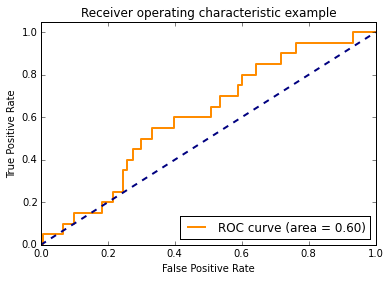

In [39]:
#plot ROC curve
fpr, tpr, _ = roc_curve(val_y, best_val_prediction)
rocauc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % rocauc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
